### Assignment 1. Download "Citeseer" graph in Pytorch Geometric and then: 

Questions:

1) Show some graph statistics of the graph, i.e., Number of nodes and Number of edges.
2) Training GCN model through dropNodes and dropEdges

In [1]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Citeseer")

data = dataset[0]

Processing...
Done!


In [2]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Citeseer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


In [3]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 48


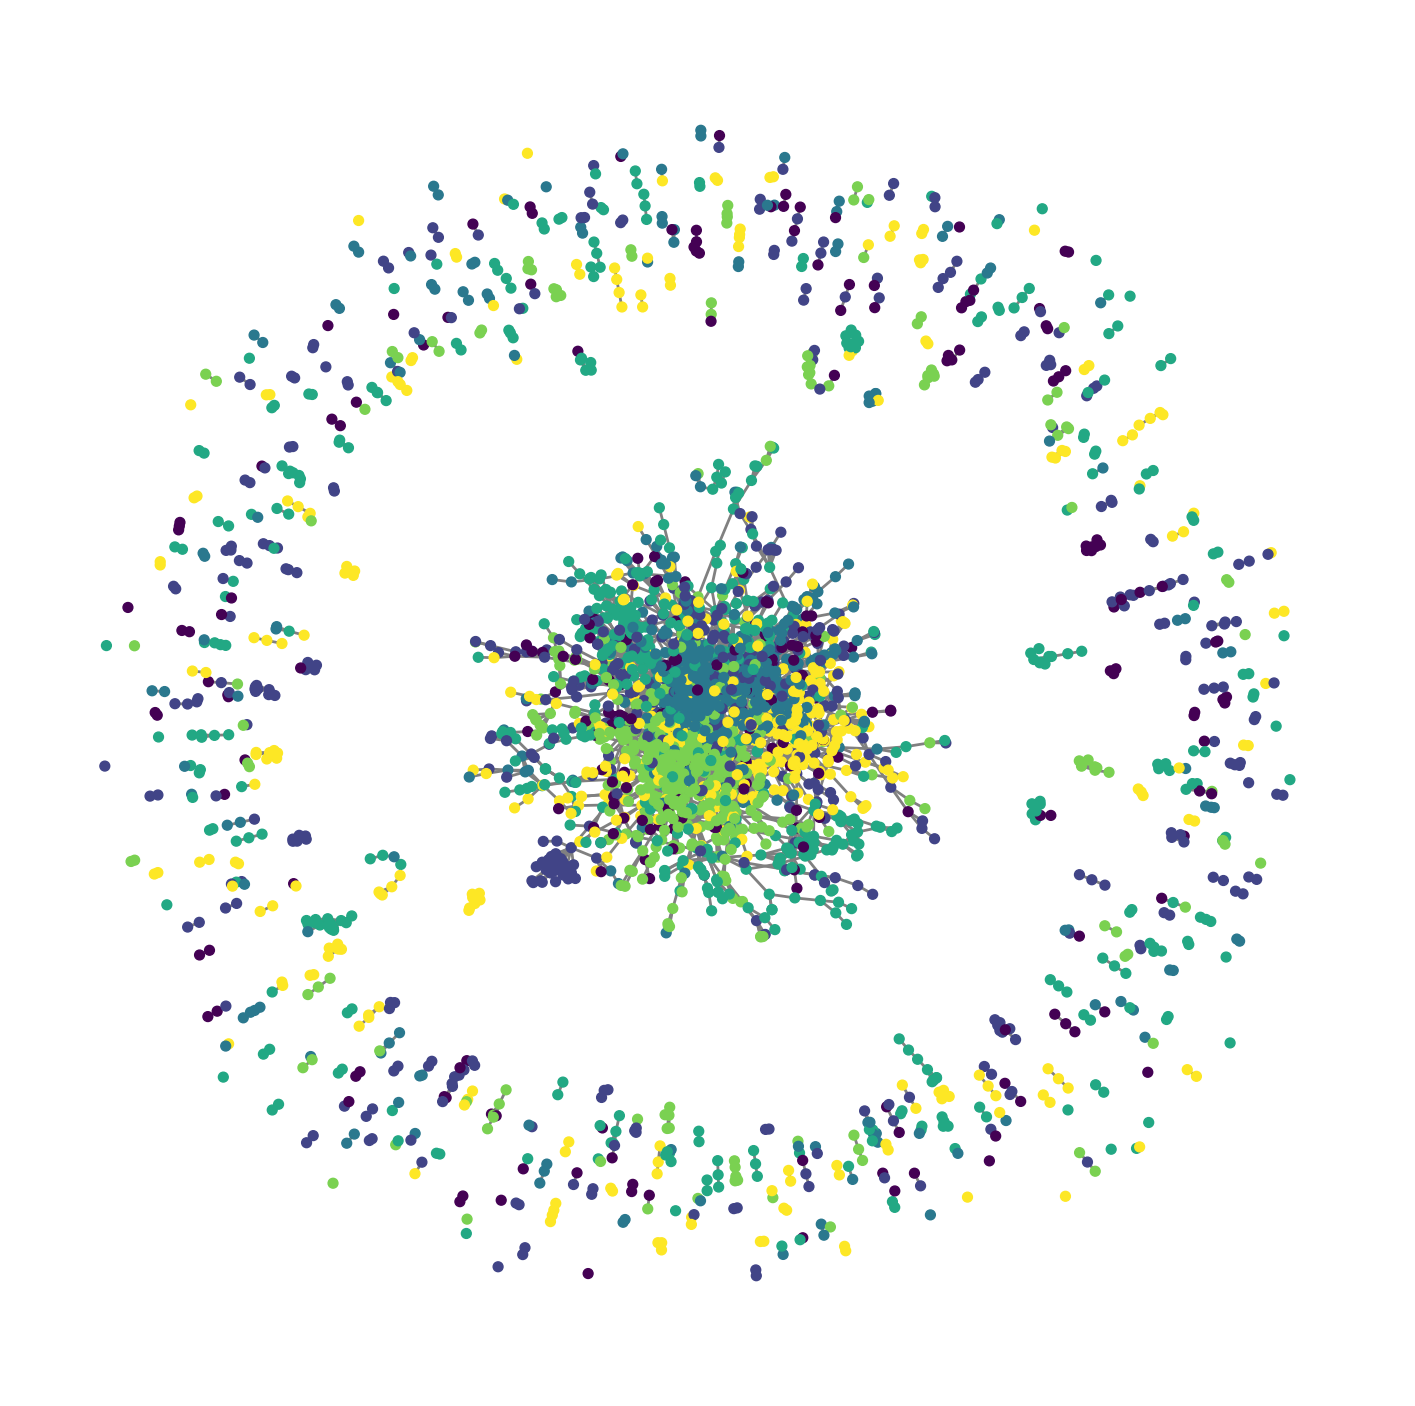

In [6]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

<BarContainer object of 32 artists>

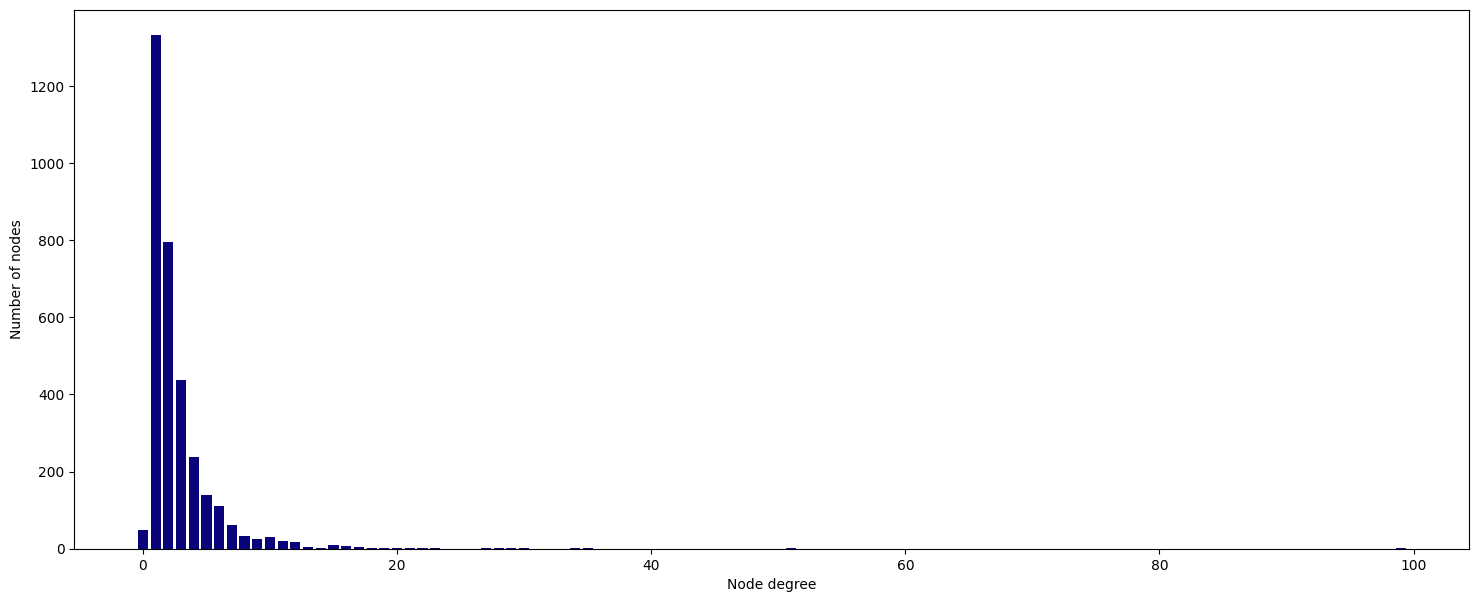

In [7]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

In [8]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data, A):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 5

    model.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        _, out = model(data.x, A)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
              f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
              f'Val Acc: {val_acc*100:.2f}%')

    return model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        h = torch.mm(adj, x)
        h = self.linear(h)
        return h

In [10]:
def drop_edges(adj, drop_prob):
    mask = (torch.rand(adj.shape) > drop_prob).float()
    dropped_adj = adj * mask
    return dropped_adj

In [11]:
class GCN_dropEdges(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(GCN_dropEdges, self).__init__()
        self.gcn1 = GCNLayer(in_features, hidden_features)
        self.gcn2 = GCNLayer(hidden_features, out_features)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

    def forward(self, x, adj):
        x = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(x, adj)
        h = F.relu(h)

        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, adj)

        return h, F.log_softmax(h, dim=1)

In [12]:
def train_dropEdges(model, data, adj, epochs=5, drop_prob=0.5):
    criterion = nn.CrossEntropyLoss()
    optimizer = model.optimizer

    for epoch in range(epochs + 1):
        model.train()
        optimizer.zero_grad()

        adj_dropped = drop_edges(adj, drop_prob)

        _,output = model(data.x, adj_dropped)

        loss = criterion(output[data.train_mask], data.y[data.train_mask])

        loss.backward()
        optimizer.step()

        train_acc = accuracy(output[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        val_loss = criterion(output[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(output[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        if epoch % 1 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{train_acc*100:.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

In [13]:
def test(model, data, adj):
    model.eval()
    with torch.no_grad():
        _, out = model(data.x, adj)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [14]:
import torch
from torch_geometric.utils import to_dense_adj

adj = to_dense_adj(data.edge_index)[0]

print(adj.shape)

torch.Size([3327, 3327])


In [15]:
%%time

gcn = GCN_dropEdges(dataset.num_features, 16, dataset.num_classes)
print(gcn)

train_dropEdges(gcn, data, adj)

acc = test(gcn, data, adj)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN_dropEdges(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=3703, out_features=16, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=16, out_features=6, bias=True)
  )
)
Epoch   0 | Train Loss: 1.810 | Train Acc: 16.67% | Val Loss: 1.85 | Val Acc: 8.40%
Epoch   1 | Train Loss: 1.670 | Train Acc: 27.50% | Val Loss: 1.71 | Val Acc: 21.60%
Epoch   2 | Train Loss: 1.563 | Train Acc: 38.33% | Val Loss: 1.67 | Val Acc: 25.20%
Epoch   3 | Train Loss: 1.534 | Train Acc: 34.17% | Val Loss: 1.68 | Val Acc: 27.20%
Epoch   4 | Train Loss: 1.475 | Train Acc: 36.67% | Val Loss: 1.62 | Val Acc: 27.60%
Epoch   5 | Train Loss: 1.366 | Train Acc: 45.83% | Val Loss: 1.60 | Val Acc: 27.40%

GCN test accuracy: 43.60%

CPU times: user 12.9 s, sys: 1.21 s, total: 14.1 s
Wall time: 1.4 s


In [16]:
def dropout_node(x, edge_index, y, train_mask, val_mask, test_mask, drop_prob=0.5):

    num_nodes = x.size(0)

    keep_mask = (torch.rand(num_nodes) > drop_prob).bool()

    new_x = x[keep_mask]

    node_idx = torch.arange(num_nodes)
    mapping = torch.zeros(num_nodes, dtype=torch.long)
    mapping[keep_mask] = torch.arange(keep_mask.sum())

    edge_mask = keep_mask[edge_index[0]] & keep_mask[edge_index[1]]
    new_edge_index = edge_index[:, edge_mask]

    new_edge_index = mapping[new_edge_index]

    new_train_mask = train_mask[keep_mask]
    new_val_mask = val_mask[keep_mask]
    new_test_mask = test_mask[keep_mask]

    new_y = y[keep_mask]

    return new_x, new_edge_index, new_y, new_train_mask, new_val_mask, new_test_mask

In [17]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        out = torch.zeros_like(x)
        out.index_add_(0, row, x[col] * norm.unsqueeze(1))
        return self.linear(out)

In [18]:
class GCN_dropNodes(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(GCN_dropNodes, self).__init__()
        self.gcn1 = GCNLayer(in_features, hidden_features)
        self.gcn2 = GCNLayer(hidden_features, out_features)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(x, edge_index)
        h = F.relu(h)

        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)

        return h, F.log_softmax(h, dim=1)

In [19]:
def train_dropNodes(model, data, epochs=5, drop_prob=0.5):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer

    model.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()

        new_x, new_edge_index, new_y, new_train_mask, new_val_mask, new_test_mask = dropout_node(
            data.x, data.edge_index, data.y, data.train_mask, data.val_mask, data.test_mask, drop_prob=drop_prob)

        _, out = model(new_x, new_edge_index)

        loss = criterion(out[new_train_mask], new_y[new_train_mask])
        acc = accuracy(out[new_train_mask].argmax(dim=1), new_y[new_train_mask])

        loss.backward()
        optimizer.step()

        val_loss = criterion(out[new_val_mask], new_y[new_val_mask])
        val_acc = accuracy(out[new_val_mask].argmax(dim=1), new_y[new_val_mask])

        if epoch % 1 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    return model

In [20]:
def test(model, data):
    model.eval()
    with torch.no_grad():
        _, out = model(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [21]:
%%time

gcn = GCN_dropNodes(dataset.num_features, 16, dataset.num_classes)
print(gcn)

train_dropNodes(gcn, data)

acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN_dropNodes(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=3703, out_features=16, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=16, out_features=6, bias=True)
  )
)
Epoch   0 | Train Loss: 1.772 | Train Acc: 19.35% | Val Loss: 1.81 | Val Acc: 17.87%
Epoch   1 | Train Loss: 1.793 | Train Acc: 24.07% | Val Loss: 1.80 | Val Acc: 24.08%
Epoch   2 | Train Loss: 1.745 | Train Acc: 28.07% | Val Loss: 1.79 | Val Acc: 24.22%
Epoch   3 | Train Loss: 1.713 | Train Acc: 31.03% | Val Loss: 1.77 | Val Acc: 25.53%
Epoch   4 | Train Loss: 1.725 | Train Acc: 23.53% | Val Loss: 1.75 | Val Acc: 27.41%
Epoch   5 | Train Loss: 1.616 | Train Acc: 41.38% | Val Loss: 1.73 | Val Acc: 26.24%

GCN test accuracy: 39.10%

CPU times: user 2.07 s, sys: 630 ms, total: 2.7 s
Wall time: 192 ms


### Assignment 2. Load the  Citeseer dataset from Torch Geometric.

Questions: Train the GCNII model with Citeseer dataset


In [22]:
dataset = Planetoid(root='/tmp/Citeseer', name='CiteSeer')

data = dataset[0]

Processing...
Done!


In [23]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj

class GCN2Conv(torch.nn.Module):
    def __init__(self, channels, alpha, theta, layer, shared_weights=True, normalize=False):
        super(GCN2Conv, self).__init__()
        self.channels = channels
        self.alpha = alpha
        self.theta = theta
        self.layer = layer
        self.shared_weights = shared_weights

        self.linear = Linear(channels, channels)

        if not shared_weights:
            self.linear_residual = Linear(channels, channels)

    def forward(self, x, x_0, adj):

        adj_norm = self.normalize_adj(adj)

        out = (1 - self.alpha) * torch.mm(adj_norm, x) + self.alpha * x_0

        out = F.relu(self.theta * out + (1 - self.theta) * F.relu(torch.mm(adj_norm, F.relu(out))))

        return out

    def normalize_adj(self, adj):
        rowsum = torch.sum(adj, dim=1)
        d_inv_sqrt = torch.pow(rowsum, -0.5)
        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = torch.diag(d_inv_sqrt)
        return torch.mm(torch.mm(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)

In [24]:
class GCNII(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=16, num_layers=2, shared_weights=True, dropout=0.0):
        super(GCNII, self).__init__()

        self.proj = Linear(1, 64)
        self.lins1 = Linear(num_features, hidden_channels)
        self.lins2 = Linear(hidden_channels, num_classes)

        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(
                GCN2Conv(hidden_channels, 0.1, 0.5, layer + 1, shared_weights)
            )

        self.dropout = dropout
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

    def forward(self, x, edge_index):
        adj = to_dense_adj(edge_index)[0]

        x = F.dropout(x, self.dropout, training=self.training)

        x = self.lins1(x)
        x_0 = x.relu()

        for conv in self.convs:
            x = F.dropout(x, self.dropout, training=self.training)
            x = conv(x, x_0, adj)

        x = F.dropout(x, self.dropout, training=self.training)
        x = self.lins2(x)
        return x, F.log_softmax(x, dim=-1)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def accuracy(output, labels, mask):
    preds = output[mask].max(1)[1]
    correct = preds.eq(labels[mask]).sum().item()
    return correct / mask.sum().item()

def train(model, optimizer, data, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        data_x = data.x.to(device)
        data_edge_index = data.edge_index.to(device)
        data_y = data.y.to(device)
        train_mask = data.train_mask.to(device)
        test_mask = data.test_mask.to(device)

        _, output = model(data_x, data_edge_index)

        loss = F.nll_loss(output[train_mask], data_y[train_mask])
        loss.backward()

        optimizer.step()

        if epoch % 10 == 0:
            acc = accuracy(output, data_y, test_mask)
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

model = GCNII(num_features=dataset.num_node_features, num_classes=dataset.num_classes, hidden_channels=16, num_layers=2, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train(model, optimizer, data)

Epoch 0, Loss: 1.8040, Accuracy: 0.1950
Epoch 10, Loss: 1.1768, Accuracy: 0.4100
Epoch 20, Loss: 0.7306, Accuracy: 0.4950
Epoch 30, Loss: 0.6707, Accuracy: 0.5060
Epoch 40, Loss: 0.5454, Accuracy: 0.5100
Epoch 50, Loss: 0.4811, Accuracy: 0.5200
Epoch 60, Loss: 0.4336, Accuracy: 0.5220
Epoch 70, Loss: 0.4212, Accuracy: 0.5230
Epoch 80, Loss: 0.4389, Accuracy: 0.5020
Epoch 90, Loss: 0.4185, Accuracy: 0.5100
Epoch 100, Loss: 0.4443, Accuracy: 0.5290
Epoch 110, Loss: 0.4324, Accuracy: 0.5210
Epoch 120, Loss: 0.4708, Accuracy: 0.5190
Epoch 130, Loss: 0.3995, Accuracy: 0.5260
Epoch 140, Loss: 0.3921, Accuracy: 0.5100
Epoch 150, Loss: 0.2916, Accuracy: 0.5130
Epoch 160, Loss: 0.3411, Accuracy: 0.5220
Epoch 170, Loss: 0.3834, Accuracy: 0.5210
Epoch 180, Loss: 0.3538, Accuracy: 0.5380
Epoch 190, Loss: 0.3639, Accuracy: 0.5360


In [26]:
def test(model, data):
    model.eval()
    with torch.no_grad():
        data_x = data.x.to(device)
        data_edge_index = data.edge_index.to(device)
        data_y = data.y.to(device)
        test_mask = data.test_mask.to(device)

        _, output = model(data_x, data_edge_index)

        acc = accuracy(output, data_y, test_mask)
        print(f"Test Accuracy: {acc:.4f}")

test(model, data)

Test Accuracy: 0.6740
